In [2]:
import tensorflow as tf
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Download Dataset

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


Preprocessing

In [4]:
# Convert unicode to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # Creating a space between a word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # Add start and end token to sentence
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
# Example
sentence = "How is the weather today?"
print(preprocess_sentence(sentence))

<start> how is the weather today ? <end>


Proprocess and create the datset in the format :[Engilsh, Spanish]

In [7]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[101])
print(sp[101])

<start> go away ! <end>
<start> largo ! <end>


In [9]:
def tokenize(lang):

  # Convert text corpus into vector, converting the words into integers. Each integer is the index of the word in the vocabulary dictionary.
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

  # Updates the internal vocabulary dictionary with the given text.
  lang_tokenizer.fit_on_texts(lang)

  # Transforms text into sequence of integers
  # Returns python list/array of sequences
  tensor = lang_tokenizer.texts_to_sequences(lang)

  # Returns numpy array of sequences with padding upto the maximum length
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

https://medium.com/analytics-vidhya/tutorial-on-bucket-by-sequence-length-api-for-efficiently-batching-nlp-data-while-training-20d8ef5219d7



In [10]:
def load_dataset(path, num_examples=None):
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Limit the size of Dataset for faster experimenting

In [14]:
size = 30000
# input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, size)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

95171 95171 23793 23793


Create Dataset

In [16]:
BUFFER_SIZE = len(input_tensor_train)
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
units = 1024
d_model = 256
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 51]), TensorShape([128, 53]))

Model: Encoder

In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, d_model, n_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.n_units = n_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.gru = tf.keras.layers.GRU(self.n_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.n_units))

In [23]:
encoder = Encoder(vocab_inp_size, d_model, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 51, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


Model: Attention Layer|

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 51, 1)


Model: Decoder

In [26]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, d_model, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, d_model)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, d_model + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [27]:
decoder = Decoder(vocab_tar_size, d_model, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 24794)


Oprtimizer and Loss function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Creating checkpoint

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Training

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [32]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5899
Epoch 1 Batch 100 Loss 0.9185
Epoch 1 Batch 200 Loss 0.7715
Epoch 1 Batch 300 Loss 0.7749
Epoch 1 Batch 400 Loss 0.7390
Epoch 1 Batch 500 Loss 0.6689
Epoch 1 Batch 600 Loss 0.6622
Epoch 1 Batch 700 Loss 0.6311
Epoch 1 Loss 0.7604
Time taken for 1 epoch 610.1199007034302 sec

Epoch 2 Batch 0 Loss 0.6575
Epoch 2 Batch 100 Loss 0.6184
Epoch 2 Batch 200 Loss 0.5951
Epoch 2 Batch 300 Loss 0.5666
Epoch 2 Batch 400 Loss 0.5668
Epoch 2 Batch 500 Loss 0.5336
Epoch 2 Batch 600 Loss 0.4917
Epoch 2 Batch 700 Loss 0.4594
Epoch 2 Loss 0.5416
Time taken for 1 epoch 561.7403774261475 sec

Epoch 3 Batch 0 Loss 0.4734
Epoch 3 Batch 100 Loss 0.4056
Epoch 3 Batch 200 Loss 0.4032
Epoch 3 Batch 300 Loss 0.3634
Epoch 3 Batch 400 Loss 0.3812
Epoch 3 Batch 500 Loss 0.3985
Epoch 3 Batch 600 Loss 0.3845
Epoch 3 Batch 700 Loss 0.3019
Epoch 3 Loss 0.3801
Time taken for 1 epoch 560.0111970901489 sec

Epoch 4 Batch 0 Loss 0.2838
Epoch 4 Batch 100 Loss 0.2601
Epoch 4 Batch 200 Loss 0.2606


In [33]:
np.save('inp_lang_word_index.npy', inp_lang.word_index)
np.save('inp_lang_index_word.npy', inp_lang.index_word)
np.save('targ_lang_word_index.npy', targ_lang.word_index)
np.save('targ_lang_index_word.npy', targ_lang.index_word)

Loading checkpoint and vocabulary dictionary

In [58]:
# checkpoint.restore('./training_checkpoints/ckpt-5')

In [59]:
inp_lang_word_index = np.load('./inp_lang_word_index.npy', allow_pickle=True).all()
inp_lang_index_word = np.load('./inp_lang_index_word.npy', allow_pickle=True).all()
targ_lang_word_index = np.load('./targ_lang_word_index.npy', allow_pickle=True).all()
targ_lang_index_word = np.load('./targ_lang_index_word.npy', allow_pickle=True).all()

In [60]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang_word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang_word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang_index_word[predicted_id] + ' '

    if targ_lang_index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> i am going to the office <end>
Predicted translation: voy a la oficina . <end> 


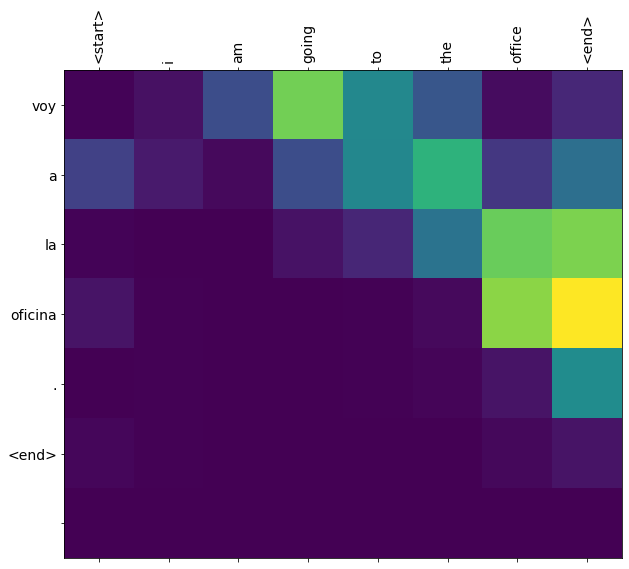

In [61]:
translate(u'I am going to the office')